In [3]:
import CalculatedFieldSubroutines as cfs

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from pandasgui import show

import matplotlib.pyplot as plt

import seaborn as sns

import warnings

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
#import in neede libraries

In [4]:
warnings.filterwarnings( 'ignore' )

In [5]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/drive/event', '/apollo/perception/traffic/light', '/apollo/canbus/chassis', '/apollo/sensor/gnss/best/pose']


In [6]:
red_combined_dfs = []

for gmID in gmID_list:

    if ( cfs.give_route( gmID ) != 'Red' ):

        continue

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df.sort_values( 'time' )

    best_pose_df.sort_values( 'time' )

    #

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.DistanceToNearestDisengagement( chassis_df )

    #

    cfs.LatLonTotalStdDev( best_pose_df )

    cfs.ProgressAlongRoute_v2( best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    #

    red_combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    #

    red_combined_df = red_combined_df[ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]

    red_combined_dfs.append( red_combined_df )

In [7]:
red_combined_df_all = pd.concat( red_combined_dfs )

In [8]:
red_combined_df_all_disengagements = red_combined_df_all[ red_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]


In [9]:
data = red_combined_df[ [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage' ] ].copy()


In [10]:
data

,brakePercentage,speedMps,throttlePercentage,steeringPercentage
0,0.0,15.90,34.4,0.675808
1,0.0,15.95,34.4,0.714985
2,0.0,15.96,34.4,0.714985
3,0.0,16.00,34.4,0.695397
4,0.0,16.06,34.4,0.695397
...,...,...,...,...
52118,0.0,4.33,0.0,-2.047013
52119,0.0,4.33,0.0,-2.066601
52120,0.0,4.31,0.0,-2.066601
52121,0.0,4.31,0.0,-2.066601


In [11]:
data = ((data - data.min())/(data.max()-data.min())) * 9 + 1

In [12]:
data.describe()

,brakePercentage,speedMps,throttlePercentage,steeringPercentage
count,52123.000000,52123.000000,52123.000000,52123.000000
mean,1.431460,6.955117,2.496603,6.121193
std,1.221101,1.699427,1.271966,0.544112
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,6.217839,1.000000,6.131543
50%,1.000000,6.931046,2.480519,6.188468
75%,1.000000,8.379074,3.259740,6.251994
max,10.000000,10.000000,10.000000,10.000000


In [13]:
def random_centroids(data,k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)
#a function that will take in the number of clusters we want with our data
#initialize a list called centroids for i in range k
#then add it to the list of centroids
#the number of centroids is equivalent to the number of clusters we want
#combines all of the centroids(individual pandas series) into a data frame

In [14]:
centroids = random_centroids(data,5)
#we can now run the random_centroids

In [15]:
centroids

,0,1,2,3,4
brakePercentage,1.000000,1.180516,1.000000,1.000000,1.000000
speedMps,7.286106,5.131046,8.573585,6.220926,7.224357
throttlePercentage,2.081169,1.000000,4.214286,3.347403,3.396104
steeringPercentage,6.396370,5.945916,6.234669,6.204143,6.030892


In [16]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)
#label each data point 
#finds the euclidean distance between a data point and each cluster for all centroids 
#finding which cluster center is closest to that point 

In [17]:
labels = get_labels(data, centroids)

In [18]:
labels.value_counts()
#how many times each value occurs 

0    17385
2    10642
1     9904
3     9534
4     4658
Name: count, dtype: int64

In [19]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids
#splits the data by each cluster and then calculate a new center for each group

In [20]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()
#Using PCA to change the multidimensional values into 2-D data
#Pass in the several column data and get it converted into 2 column data
#plotting the clusters and coloring from the plotting of centroids 
#will wait and change the graph over the already completed graph 

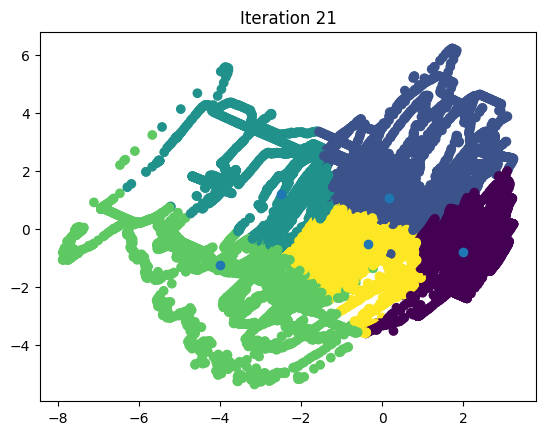

In [21]:
max_iterations = 100
centroid_count = 5

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1
#when new centroids are equilavent to past centroids (indicates that it has stopped shifting)
#update the data to see which label corresponds with each cluster

In [27]:
c0 = red_combined_df[labels ==0][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c1 = red_combined_df[labels ==1][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c2 = red_combined_df[labels ==2][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c3 = red_combined_df[labels ==3][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c4 = red_combined_df[labels ==4][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]

KeyError: False

In [31]:
c0.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,13391.000000,13391.000000,1.339100e+04,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000
mean,0.237704,26.169624,1.702488e+18,19.593331,0.094819,0.000075,-220.976542,-82.049897,39.346009,0.046947,0.711536,70.657681
std,2.167929,1.349686,3.802181e+11,10.387848,0.753035,0.019324,1385.547855,0.032321,0.020922,0.177064,0.224060,22.392668
min,0.000000,21.670000,1.702487e+18,0.000000,-1.841332,-1.000000,-2959.198474,-82.101975,39.325856,0.012996,0.099801,9.000000
25%,0.000000,25.130000,1.702488e+18,14.100000,-0.235064,0.000000,-1158.661187,-82.081349,39.332368,0.015759,0.659571,65.000000
50%,0.000000,26.410000,1.702488e+18,21.400000,-0.048972,0.000000,-250.454101,-82.049154,39.334404,0.017237,0.756037,75.000000
75%,0.000000,26.950000,1.702489e+18,25.900000,0.303624,0.000000,669.182884,-82.022595,39.353167,0.019250,0.877972,87.000000
max,29.800000,29.150000,1.702489e+18,55.200000,3.623898,1.000000,3037.741199,-81.992293,39.402676,1.754494,0.975454,97.000000


In [32]:
c1.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,15630.000000,15630.000000,1.563000e+04,15630.000000,15630.000000,15630.000000,15630.000000,15630.000000,15630.000000,15630.000000,15630.000000,15630.000000
mean,0.010429,18.056385,1.702488e+18,26.251401,-0.008349,-0.000576,-810.383496,-82.028576,39.372181,0.210124,0.351737,34.652847
std,0.538789,2.315155,4.118624e+11,11.429547,2.623744,0.023990,1977.623857,0.041815,0.024087,0.500326,0.227282,22.731501
min,0.000000,9.610000,1.702487e+18,13.600000,-14.887365,-1.000000,-6122.345547,-82.105626,39.324398,0.012233,0.000532,0.000000
25%,0.000000,16.970000,1.702487e+18,18.800000,-0.666014,0.000000,-1813.085317,-82.067887,39.349133,0.018616,0.151586,15.000000
50%,0.000000,17.930000,1.702488e+18,22.900000,0.009794,0.000000,-559.395359,-82.019270,39.378349,0.024936,0.336751,33.000000
75%,0.000000,19.660000,1.702488e+18,29.100000,0.930460,0.000000,464.730778,-81.990294,39.393689,0.045116,0.519361,51.000000
max,41.600000,25.220000,1.702489e+18,92.400000,9.637610,0.000000,3119.448207,-81.979182,39.404472,2.239439,0.994906,99.000000


In [33]:
c2.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,4523.000000,4523.000000,4.523000e+03,4523.000000,4523.000000,4523.000000,4523.000000,4523.000000,4523.000000,4523.000000,4523.000000,4523.000000
mean,0.766748,10.731083,1.702488e+18,10.218373,-4.919745,-0.000442,-1173.998720,-82.032297,39.359539,0.380424,0.514741,50.970816
std,2.672526,3.363467,5.336926e+11,9.075207,15.069255,0.021026,2202.561287,0.057932,0.012513,0.769204,0.313328,31.299534
min,0.000000,0.000000,1.702487e+18,0.000000,-56.150833,-1.000000,-5479.054772,-82.105814,39.324334,0.011770,0.019223,1.000000
25%,0.000000,9.600000,1.702488e+18,3.900000,-6.229187,0.000000,-1423.128105,-82.096517,39.353259,0.016670,0.450143,45.000000
50%,0.000000,11.430000,1.702488e+18,8.100000,-0.538688,0.000000,-435.700791,-81.989734,39.361040,0.033894,0.501651,50.000000
75%,0.000000,13.400000,1.702488e+18,14.300000,0.215475,0.000000,2.044356,-81.980232,39.369311,0.079197,0.606871,60.000000
max,21.800000,14.490000,1.702489e+18,47.000000,45.190990,0.000000,2058.428271,-81.979035,39.385237,2.979370,1.000000,99.000000


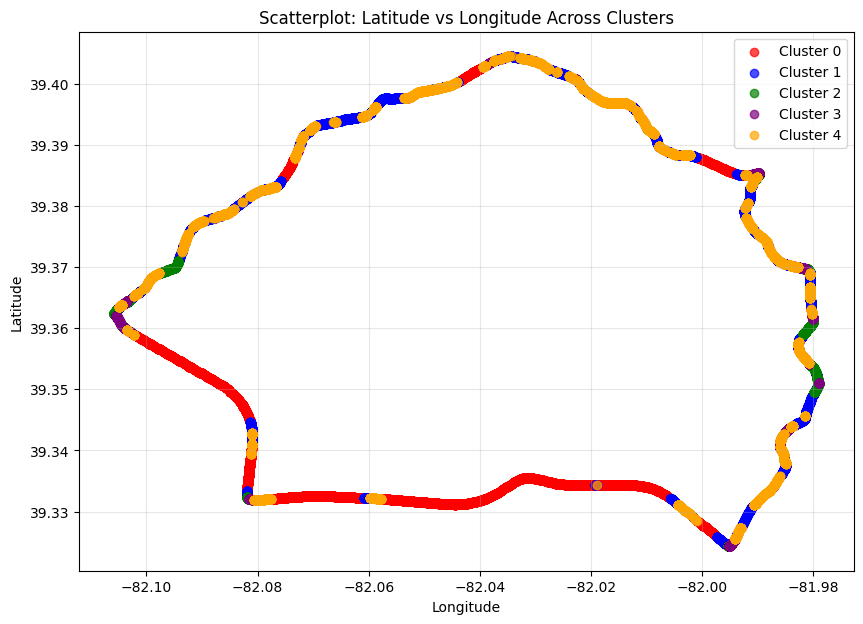

In [25]:
import matplotlib.pyplot as plt

# Define cluster data and colors
clusters = [c0, c1, c2, c3, c4]
colors = ['red', 'blue', 'green', 'purple', 'orange']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Initialize plot
plt.figure(figsize=(10, 7))

# Plot each cluster using latitude and longitude
for i, cluster in enumerate(clusters):
    plt.scatter(cluster['longitude'], cluster['latitude'], 
                color=colors[i], label=labels[i], alpha=0.7)

# Add titles and labels
plt.title("Scatterplot: Latitude vs Longitude Across Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)

# Show plot
plt.show()
